In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../../../")

In [4]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from castle.algorithms import PC
from dowhy import CausalModel

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import (convert_aspect_to_cardinal_direction, 
                                    convert_canopy_cover_to_classes,
                                    convert_elevation_to_classes, 
                                    convert_slope_to_classes, 
                                    convert_ffmc_to_classes)

In [5]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

In [6]:
# read training data
train_data = gpd.read_file(paths["training_data"])

train_data.rename(columns={"farmyard_d": "farmyard_density", 
                           "hiking_ds": "hikingtrail_density", 
                           "forest_ds": "forestroad_density", 
                           "rail_dens": "railway_density", 
                           "foresttype": "forest_type", 
                           "pop_dens": "population_density", 
                           "canopy_cov": "canopy_cover"}, inplace=True)

In [7]:
# data preprocessing
train_data.dropna(subset=("forest_type", "canopy_cover"), inplace=True)
train_data["elevation_encoded"] = train_data["elevation"].apply(convert_elevation_to_classes)
train_data["slope_encoded"] = train_data["slope"].apply(convert_slope_to_classes)
train_data["aspect_encoded"] = train_data["aspect"].apply(convert_aspect_to_cardinal_direction)
train_data["canopy_cover_encoded"] = train_data["canopy_cover"].apply(convert_canopy_cover_to_classes)
train_data["ffmc_encoded"] = train_data["ffmc"].apply(convert_ffmc_to_classes)
train_data["forest_type"] = train_data["forest_type"].astype("int64")

relevant_columns = ["elevation_encoded", "slope_encoded", "aspect_encoded", 
                    "canopy_cover_encoded", "forest_type", 
                    "ffmc_encoded", "fire"]


X = train_data.loc[:, relevant_columns]

In [8]:
# causal graph learning
pc = PC(ci_test='chi2')
pc.learn(X.values)

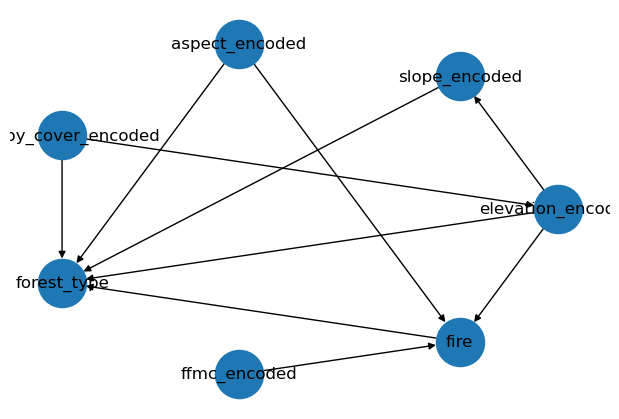

In [23]:
# graph visualization
g = nx.DiGraph(pc.causal_matrix)
plt.figure(figsize=(6, 4))
nx.draw(
    G=g,
    node_size=1200,
    pos=nx.circular_layout(g)
)

node_labels = {n: X.columns[n] for n in g.nodes()}  # Assuming node labels are node indices
nx.draw_networkx_labels(g, nx.circular_layout(g), labels=node_labels)

plt.show()

NodeView((0, 1, 2, 3, 4, 5, 6))

In [22]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=X,
    treatment="forest_type",
    outcome="fire",
    graph=g) 

2024-03-19 13:21:29,061 - c:\Users\b1105474\AppData\Local\miniconda3\envs\causal_discovery\lib\site-packages\dowhy\causal_graph.py[line:99] - ERROR: Incorrect format: Please provide graph as a networkx DiGraph, GCM model, or as a string or text file in dot, gml format.
2024-03-19 13:21:29,061 - c:\Users\b1105474\AppData\Local\miniconda3\envs\causal_discovery\lib\site-packages\dowhy\causal_graph.py[line:100] - ERROR: Error: Incorrect graph format


ValueError: Incorrect format: Please provide graph as a networkx DiGraph, GCM model, or as a string or text file in dot, gml format.

In [13]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect()

NodeNotFound: Either source forest_type or target fire is not in G

In [15]:
import dowhy.datasets

# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True)

In [19]:
data["df"]

,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,1.0,0.176990,1.121873,-1.148133,-0.509288,-0.585521,1.005803,True,11.954150
1,1.0,0.276512,1.997032,-1.085534,0.268933,0.248666,1.639782,True,23.222682
2,1.0,0.553305,1.716509,-1.912652,-0.174083,-1.432610,-1.645039,True,-3.925457
3,1.0,0.579786,1.488089,-0.224751,-2.364592,-0.299995,0.636115,True,14.099516
4,1.0,0.081588,1.025118,0.416728,0.039640,-1.443057,0.715150,True,11.628320
...,...,...,...,...,...,...,...,...,...
9995,1.0,0.228530,1.825405,-1.594916,0.278318,1.382891,1.080158,True,23.861734
9996,1.0,0.246105,-0.170995,0.169549,1.159876,-0.375406,-1.561398,True,2.160922
9997,1.0,0.421999,1.693844,-1.054574,-0.515678,0.278132,0.620776,True,16.859669
9998,0.0,0.144583,1.025648,1.435223,1.784215,-0.274783,0.974601,True,23.406712
